In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from scipy import stats

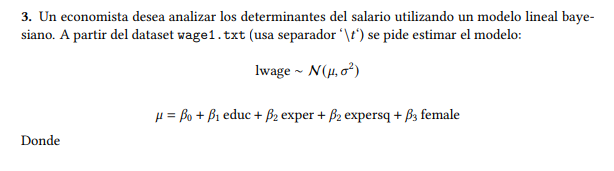

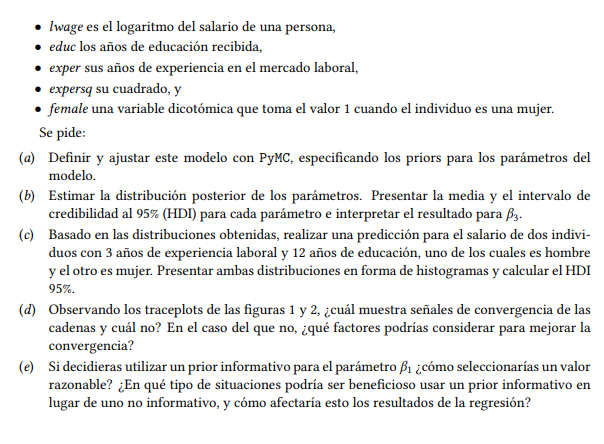

In [7]:
data = pd.read_csv("C:/Users/Usuario/Estadistica/Estadistica-Inferencia/PARCIAL2/wage1.txt", sep='\t')

print(data.shape)
print(data.columns)

(526, 24)
Index(['clerocc', 'construc', 'educ', 'exper', 'expersq', 'female', 'lwage',
       'married', 'ndurman', 'nonwhite', 'northcen', 'numdep', 'profocc',
       'profserv', 'services', 'servocc', 'smsa', 'south', 'tenure', 'tenursq',
       'trade', 'trcommpu', 'wage', 'west'],
      dtype='object')


Defino mi modelo. 
El modelo tiene una distribucion normal con mu y sigma **2, donde el mu es una regresion lineal basada en diversas variables del dataset.
Elijo rpiors normales no informativos para los beta de la regresion.

In [9]:
X1 = data["educ"].values.flatten()
X2 = data["exper"].values.flatten()
X3 = (data["exper"] ** 2).values.flatten()
X4 = data["female"].values.flatten()
Y = data["lwage"].values.flatten()

# Estandarizo a X para ayudar al algoritmo a converger más rápido
X1_est = (X1 - np.mean(X1)) / np.std(X1)
X2_est = (X2 - np.mean(X2)) / np.std(X2)
X3_est = (X3 - np.mean(X3)) / np.std(X3)
X4_est = (X4 - np.mean(X4)) / np.std(X4)
Y_est = (Y - np.mean(Y)) / np.std(Y)


In [14]:
with pm.Model() as lwage:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    b1 = pm.Normal("b1", mu=0, sigma=5)
    b2 = pm.Normal("b2", mu=0, sigma=5)
    b3 = pm.Normal("b3", mu=0, sigma=5)
    b4 = pm.Normal("b4", mu=0, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    mu = intercept + b1 * X1_est + b2 * X2_est + b3 * X3_est + b4 * X4_est

    lwage_obs = pm.Normal("lwage_obs", mu=mu, sigma=sigma, observed=Y_est)
    trace = pm.sample(400, return_inferencedata=True)


az.summary(trace, hdi_prob=0.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, b1, b2, b3, b4, sigma]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 400 draw iterations (4_000 + 1_600 draws total) took 717 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.001,0.034,-0.068,0.064,0.001,0.001,2168.0,965.0,1.01
b1,0.439,0.036,0.376,0.515,0.001,0.001,1822.0,1154.0,1.01
b2,0.993,0.124,0.756,1.233,0.004,0.003,1161.0,1081.0,1.00
b3,-0.795,0.124,-1.032,-0.554,0.004,0.003,1142.0,1016.0,1.00
b4,-0.317,0.034,-0.383,-0.253,0.001,0.001,1786.0,790.0,1.00
sigma,0.781,0.023,0.736,0.824,0.001,0.000,1634.0,935.0,1.00


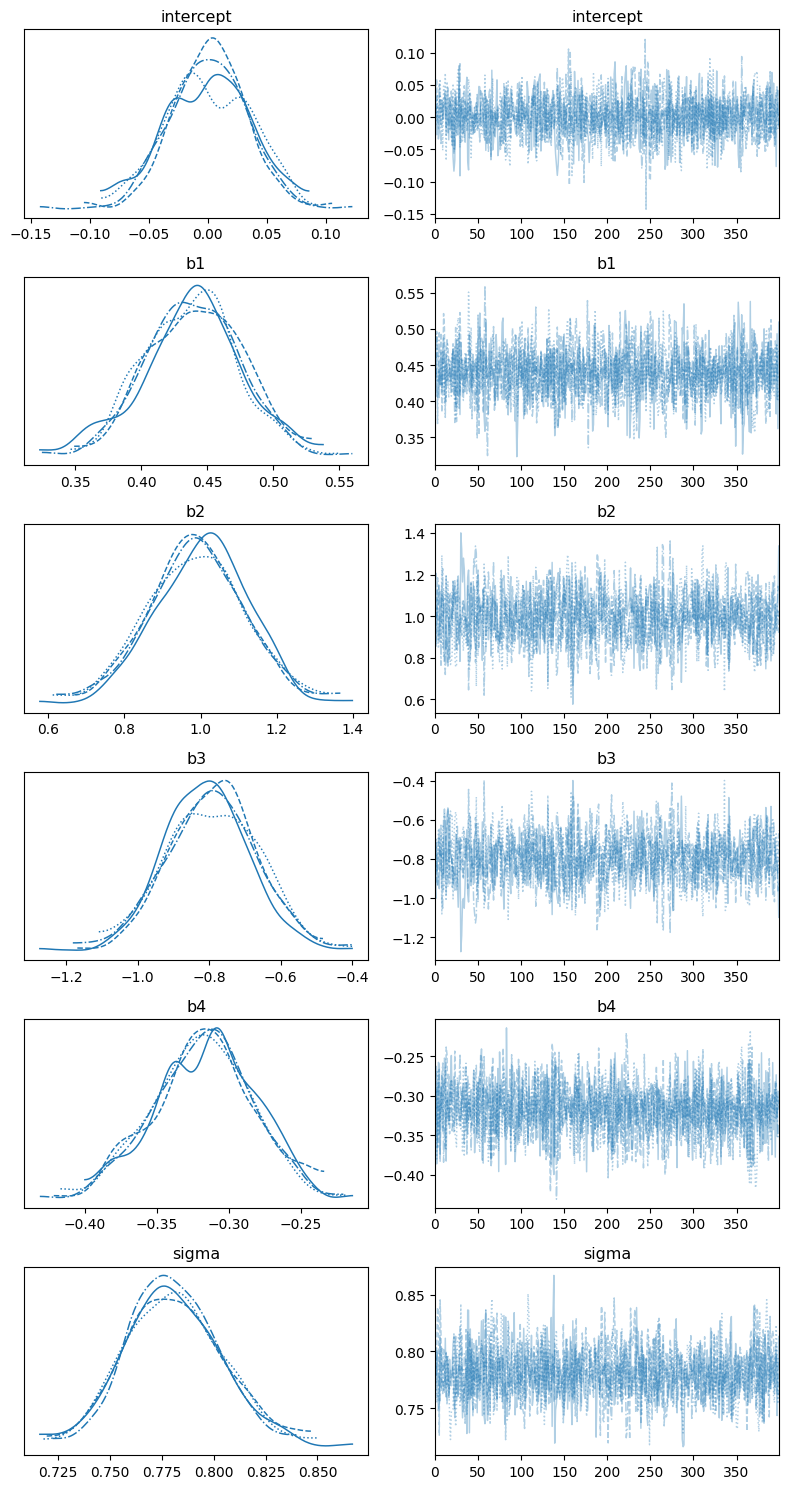

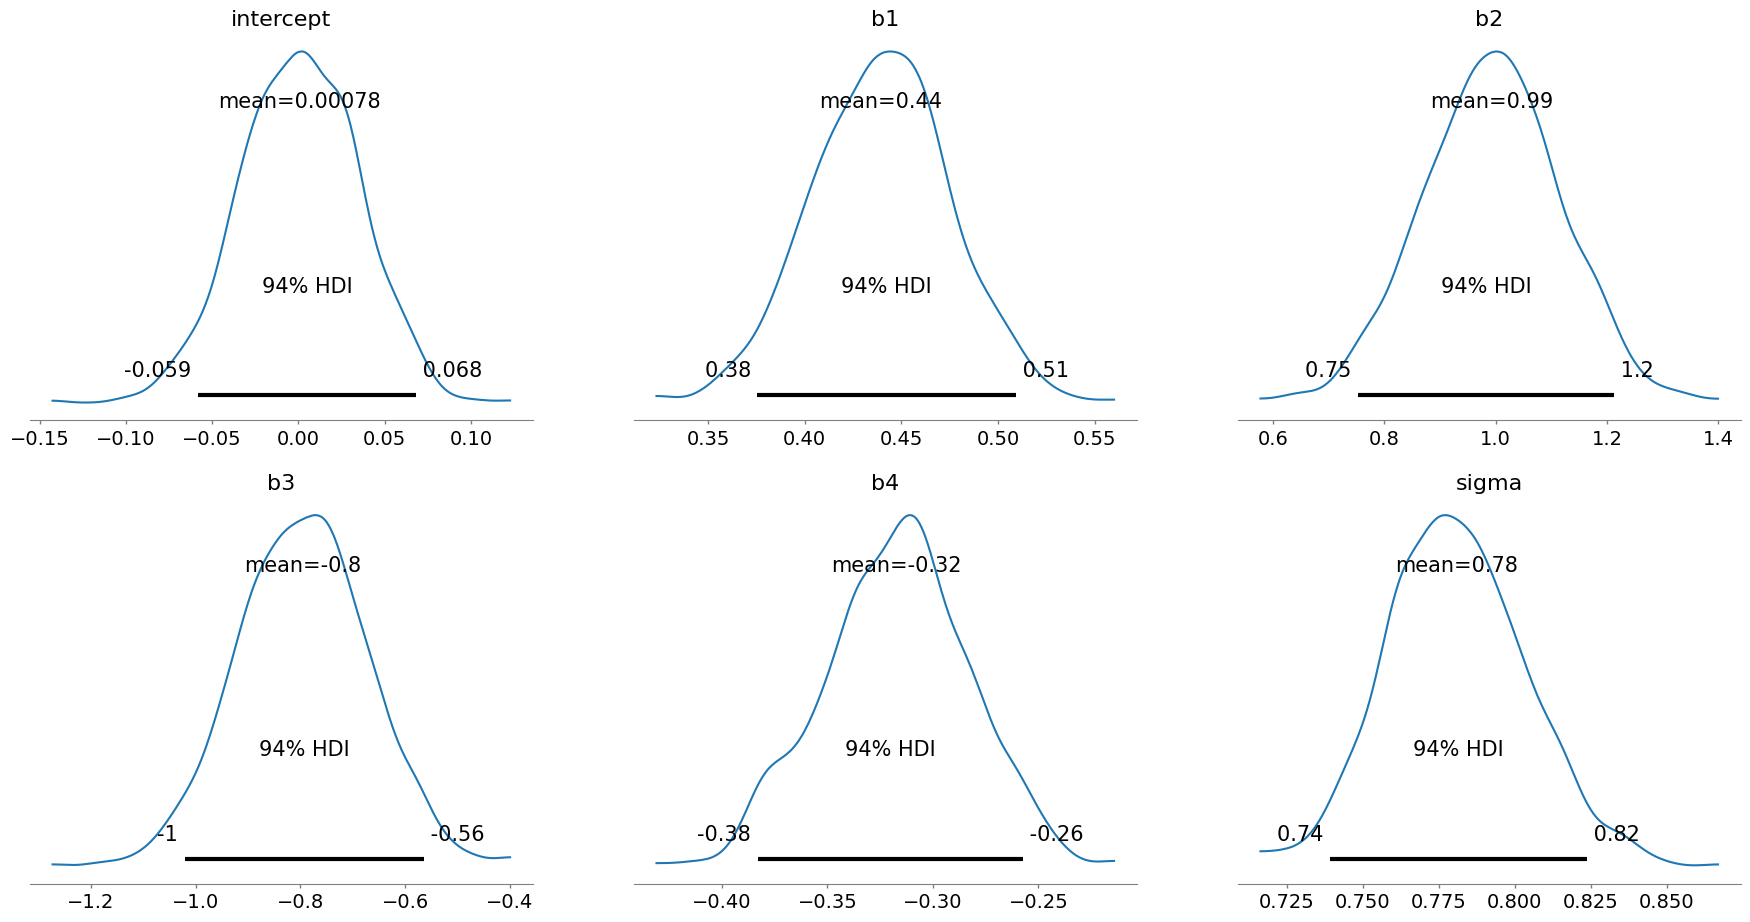

In [19]:
az.plot_trace(trace,figsize= (8,15))
plt.tight_layout()
plt.show()

az.plot_posterior(trace)
plt.show()


Calculo el intervalo de HDI 95%

In [18]:
summary = az.summary(trace, var_names=["intercept", "b1", "b2", "b3", "b4", "sigma"], hdi_prob=0.95)
print("\nEstadísticas resumen (media y HDI 95%) de los parámetros estimados:")
print(summary)


Estadísticas resumen (media y HDI 95%) de los parámetros estimados:
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  0.001  0.034    -0.068      0.064      0.001    0.001    2168.0   
b1         0.439  0.036     0.376      0.515      0.001    0.001    1822.0   
b2         0.993  0.124     0.756      1.233      0.004    0.003    1161.0   
b3        -0.795  0.124    -1.032     -0.554      0.004    0.003    1142.0   
b4        -0.317  0.034    -0.383     -0.253      0.001    0.001    1786.0   
sigma      0.781  0.023     0.736      0.824      0.001    0.000    1634.0   

           ess_tail  r_hat  
intercept     965.0   1.01  
b1           1154.0   1.01  
b2           1081.0   1.00  
b3           1016.0   1.00  
b4            790.0   1.00  
sigma         935.0   1.00  


La manera en la que interpreto el do para b3, es que como la totalidad del intervalo tiene valores negativos, se puede decir que ser de sexo fememino tiene un impacto negativo en el sueldo. Si el intervalo tuviera valores negativos y positivos, no se podria concluir que tiene un impacto. 


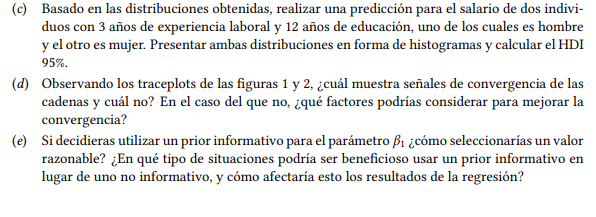

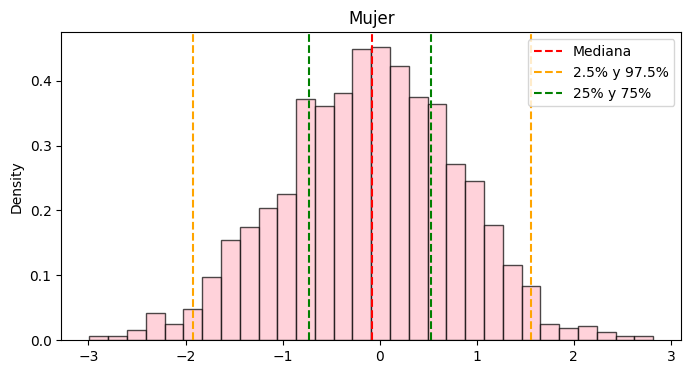

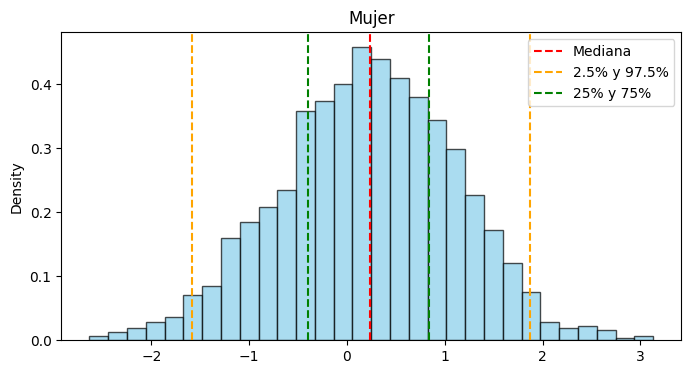

In [20]:
exp = 3
edu = 10

posterior_samples = trace.posterior

mujer = posterior_samples["intercept"].values + edu * posterior_samples['b1'].values + exp * posterior_samples['b2'].values + (exp**2) * posterior_samples['b3'].values + posterior_samples['b4'].values
mujer = np.array(mujer).flatten()
percentiles = np.percentile(mujer, [2.5, 25, 50, 75, 97.5])

plt.figure(figsize=(8, 4))
plt.hist(mujer, bins=30, density=True, color="pink", alpha=0.7, edgecolor="black")
plt.axvline(percentiles[2], color="red", linestyle="--", label="Mediana")
plt.axvline(percentiles[0], color="orange", linestyle="--", label="2.5% y 97.5%")
plt.axvline(percentiles[4], color="orange", linestyle="--")
plt.axvline(percentiles[1], color="green", linestyle="--", label="25% y 75%")
plt.axvline(percentiles[3], color="green", linestyle="--")
plt.ylabel("Density")
plt.title("Mujer")
plt.legend()
plt.show()

varon = posterior_samples["intercept"].values + edu * posterior_samples['b1'].values + exp * posterior_samples['b2'].values + (exp**2) * posterior_samples['b3'].values
varon = np.array(varon).flatten()
percentiles = np.percentile(varon, [2.5, 25, 50, 75, 97.5])
plt.figure(figsize=(8, 4))
plt.hist(varon, bins=30, density=True, color="skyblue", alpha=0.7, edgecolor="black")
plt.axvline(percentiles[2], color="red", linestyle="--", label="Mediana")
plt.axvline(percentiles[0], color="orange", linestyle="--", label="2.5% y 97.5%")
plt.axvline(percentiles[4], color="orange", linestyle="--")
plt.axvline(percentiles[1], color="green", linestyle="--", label="25% y 75%")
plt.axvline(percentiles[3], color="green", linestyle="--")
plt.ylabel("Density")
plt.title("Mujer")
plt.legend()
plt.show()

Creo que de todos los traceplots, creo que el del intercepto y el de b4 son los que menos convergen, los otros si vien no es exacto, parecen encontrar los mismos puntos

Para evaluar una mejor convergencia creo que habria que tener mas puntos en la traza, pero sino no me convergia el modelo

In [ ]:
with pm.Model() as lwage_infromativo:
    
    intercept = pm.HalfNormal("intercept", mu=np.mean(data["lwage"].values.flatten()), sigma=10) #pondria de base un intercept positivo y que la media sea la media de los datos (como estimador a groso modo de los salarios promedio)
    b1 = pm.Normal("b1", mu=0, sigma=5) 
    # para poner un prior informativo en b1 cambiaria em mu, y para estimar el valor se podria hacer otro modelo que relacione solamente este valor con el salario,
    # obtener la media y poner a esa media como mu en el prior
    #tambien se podria estimar un sigma de este modelo jerarquico, y reemplazarlo en este caso
    
    b2 = pm.Normal("b2", mu=0, sigma=5)
    b3 = pm.Normal("b3", mu=0, sigma=10)
    b4 = pm.Normal("b4", mu=0, sigma=10) 

    #esa misma idea es valida para cualquiera de los beta

    sigma = pm.HalfNormal("sigma", sigma=10) 
    
    mu = intercept + b1 * X1_est + b2 * X2_est + b3 * X3_est + b4 * X4_est
    
    lwage_obs = pm.Normal("lwage_obs", mu=mu, sigma=sigma, observed=Y_est)

    trace = pm.sample(2000, tune=1000, return_inferencedata=True)